# Investigating English Phonotactics #
In the notebook `Model Training.ipynb` I trained a language model over English pronunciations from [the CMU Pronouncing Dictionary](http://www.speech.cs.cmu.edu/cgi-bin/cmudict). CMU Dict contains phonetic representations of about 125,000 words, so the goal of the language model is to learn what sequences of sounds constitute good words.

In this notebook I use the model to:
1. **Identify which English pronunciations are most- and least-Englishlike**. For example, I would expect "fun" to sound normal and a borrowed word like "cliché" to be less normal.
2. **Generate novel words** that aren't English words but sound like they could be.

I'll also dig into what the model has learned to see whether it has learned the [phonotactics rules](https://en.wikipedia.org/wiki/Phonotactics) that all English speakers subconsciously understand.

Note that pronunciations are in [ARPABET](https://en.wikipedia.org/wiki/ARPABET), a set of symbols representing English sounds. It's a subset of the more popular [International Phonetic Alphabet](https://en.wikipedia.org/wiki/International_Phonetic_Alphabet). If you know IPA you can pick up the equivalent ARPABET from looking at the Wikipedia page.

In [1]:
from operator import itemgetter

import pandas as pd
import torch
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

from sonorous.analysis_utils import plot_next_phoneme_distribution, plot_pronunciation_probability
from sonorous.languagemodel import LanguageModel
from sonorous.utils import perplexity
from sonorous.pronunciationdata import augment_pronunciations_df, load_pronunciations

In [2]:
pd.options.display.max_rows = 500
pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 255

First I'll load the model that I trained in `Model Training.ipynb`, as well as all of the pronunciations from CMU Dict.

In [3]:
with open('model_1_100_3.pt', 'rb') as fh:
    language_model = LanguageModel.load(fh, device_name='cpu')

language_model

LanguageModel(
  (_encoder): Embedding(72, 100)
  (_rnn): GRU(100, 3, batch_first=True)
  (_decoder): Linear(in_features=3, out_features=72, bias=True)
  (_dropout): Dropout(p=0, inplace=False)
)

In [4]:
pronunciations = load_pronunciations()
print(f"There are {len(pronunciations):,} pronunciations.")
print()
print("Sample of 5 pronunciations:")

pronunciations.sample(5)

There are 125,801 pronunciations.

Sample of 5 pronunciations:


,pronunciation,num_phonemes,num_syllables
word,,,
freire,"(F, R, IH1, R)",4,1
budin,"(B, UW1, D, IH0, N)",5,2
underscoring,"(AH2, N, D, ER0, S, K, AO1, R, IH0, NG)",10,4
ehret,"(EH1, R, IH0, T)",4,2
skipping,"(S, K, IH1, P, IH0, NG)",6,2


In [54]:
# TODO: this is in utils now, so delete
pronunciations['num_primary_stressed_syllables'] = pronunciations.pronunciation.apply(lambda pronunciation: sum(1 for phoneme in pronunciation if phoneme.endswith('1')))

## What Words are the Most and Least Englishy? ##
Since the model can assign a probability to any pronunciation, I can run it over the entire set of pronunciations in the Pronouncing Dictionary and identify the ones that have high and low likelihood of being English.

I'll be using [perplexity](https://en.wikipedia.org/wiki/Perplexity) as a measurement of how likely the model thinks each pronunciation is.

In [5]:
pronunciations['perplexity'] = pronunciations.pronunciation.apply(language_model.perplexity_of_text)
pronunciations.sort_values('perplexity', inplace=True)

Let's look at the least perplexing words. These are the ones the model was totally unsurprised because they seem very normal.

In [55]:
least_perplexing = pronunciations.head(10)
least_perplexing

,pronunciation,num_phonemes,num_syllables,perplexity,num_primary_stressed_syllables
word,,,,,
renton,"(R, EH1, N, T, AH0, N)",6,2,7.880087,1
catalan,"(K, AE1, T, AH0, L, AH0, N)",7,3,7.926647,1
melanin,"(M, EH1, L, AH0, N, AH0, N)",7,3,8.020210,1
kenton,"(K, EH1, N, T, AH0, N)",6,2,8.108158,1
callanan,"(K, AE1, L, AH0, N, AH0, N)",7,3,8.196656,1
lenton,"(L, EH1, N, T, AH0, N)",6,2,8.205855,1
lanolin,"(L, AE1, N, AH0, L, AH0, N)",7,3,8.299688,1
marilynn,"(M, EH1, R, AH0, L, AH0, N)",7,3,8.300134,1
marilyn,"(M, EH1, R, AH0, L, AH0, N)",7,3,8.300134,1


In [56]:
pronunciations.loc['environmentalism']

,pronunciation,num_phonemes,num_syllables,perplexity,num_primary_stressed_syllables
word,,,,,
environmentalism,"(EH0, N, V, AY1, R, AH0, N, M, EH2, N, AH0, L, IH2, Z, AH0, M)",16,7,24.217822,1
environmentalism,"(EH0, N, V, AY1, R, AH0, N, M, EH2, N, T, AH0, L, IH2, Z, AH0, M)",17,7,25.519437,1


The ten least perplexing words have very regular structure. In all of them the first syllable is stressed and the final syllable is /AH0 N/. There are lots of schwas (/AH0/), which is the most neutral vowel in English.

I trained a number of different models and looked at their least perplexing words. The more complex models all had very long words as the least perplexing, which showed that the model had basically memorized actual English words. "Environmentalism", for example, had a very low perplexity because the once the model saw /EH0 N V AY1 R/ it seemed to know that there were only a few possible endings. The model we're looking at though seems to have struck a nice balance.

The least perplexing long words (five or more syllables) also display a lot of regularity.

In [57]:
pronunciations[pronunciations.num_syllables>=5].head()

,pronunciation,num_phonemes,num_syllables,perplexity,num_primary_stressed_syllables
word,,,,,
concatenating,"(K, AH0, N, K, AE1, T, AH0, N, EY2, T, IH0, NG)",12,5,12.114662,1
procrastinating,"(P, R, AH0, K, R, AE1, S, T, AH0, N, EY2, T, IH0, NG)",14,5,12.194682,1
procrastinator,"(P, R, AH0, K, R, AE1, S, T, AH0, N, EY2, T, ER0)",13,5,13.095788,1
contaminating,"(K, AH0, N, T, AE1, M, AH0, N, EY2, T, IH0, NG)",12,5,13.140277,1
uncollectable,"(AH0, N, K, AH0, L, EH1, K, T, AH0, B, AH0, L)",12,5,13.271295,1


Now let's look at the high perplexity words-- those that the model is surprised by.

In [58]:
pronunciations.sort_values('perplexity', ascending=False).head(10)

,pronunciation,num_phonemes,num_syllables,perplexity,num_primary_stressed_syllables
word,,,,,
are,"(ER0,)",1,1,138859.122831,0
er,"(ER0,)",1,1,138859.122831,0
or,"(ER0,)",1,1,138859.122831,0
ow,"(AW1,)",1,1,122324.888664,1
aue,"(AW1,)",1,1,122324.888664,1
uh,"(AH1,)",1,1,94183.291499,1
uhh,"(AH1,)",1,1,94183.291499,1
sh,"(SH,)",1,0,91141.166429,0
shh,"(SH,)",1,0,91141.166429,0


All of these are one syllable words. As you can see in the histogram below, single phoneme words are incredibly rare in the CMU Dict so it makes sense the model would be surprised by these.

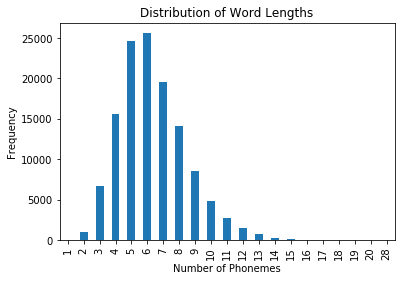

In [49]:
pronunciations.num_phonemes.value_counts().sort_index().plot.bar()
plt.xlabel('Number of Phonemes')
plt.ylabel('Frequency')
_ = plt.title('Distribution of Word Lengths')

Below are the most perplexing words that have at least two phonemes.

In [59]:
pronunciations[pronunciations.num_phonemes > 1].sort_values('perplexity', ascending=False).head(20)

,pronunciation,num_phonemes,num_syllables,perplexity,num_primary_stressed_syllables
word,,,,,
ainge,"(EY1, NG)",2,1,10078.350085,1
ai,"(EY1, AY1)",2,2,6758.279094,2
hiaa,"(EY1, CH, AY1, EY1, EY1)",5,4,6711.688510,4
hmm,"(HH, M)",2,0,5024.130742,0
hm,"(HH, M)",2,0,5024.130742,0
hmmm,"(HH, M)",2,0,5024.130742,0
is,"(IH0, Z)",2,1,4876.104230,0
aoi,"(AW1, IY0)",2,2,4702.963188,1
aer,"(EY1, IY1, AA1, R)",4,3,4450.537587,3


There are some interesting patterns here. Many of these are actually pronunciations of acronyms. For example, "ai" . is /EY1 AY1/, where /EY1/ is "a" and /AY1/ is "i". You can identify acronyms and compound words by how many primary-stressed syllables they contain: a word will only have one primary stressed syllable.

The words that do have just one primary-stressed syllable sound strange to me: /EY1 NG/, /AW1 IY0/, /OY1 ER0/. So I think the model has done a good job here!

I found that for longer pronunciations (e.g. 5+ phonemes), the most perplexing words are almost all acronyms. Below I drop those by removing pronunciations with more than one syllable with primary stress, which works because normal words only have one primary stress.

In [60]:
pronunciations[(pronunciations.num_phonemes > 5) & (pronunciations.num_primary_stressed_syllables == 1)].sort_values('perplexity', ascending=False).head(20)

,pronunciation,num_phonemes,num_syllables,perplexity,num_primary_stressed_syllables
word,,,,,
kwangju,"(K, W, AA0, NG, JH, UW1)",6,2,390.133280,1
jambor,"(Y, AA0, M, B, AO1, R)",6,2,330.894242,1
janthina,"(Y, AA0, N, TH, IY1, N, AH0)",7,3,328.836086,1
lagroceria,"(L, AA0, G, R, OW2, S, ER0, IY1, AH2)",9,5,315.445837,1
agarwal,"(AA1, G, AA0, R, W, AA0, L)",7,3,314.874608,1
maharaja,"(M, AA2, HH, ER0, AA1, ZH, AH2)",7,4,313.583086,1
kwangju,"(G, W, AA0, NG, JH, UW1)",6,2,310.485710,1
hayenga,"(HH, EY0, EY1, NG, G, AH0)",6,3,297.175091,1
angermeier,"(EY1, NG, G, ER0, M, AY0, ER0)",7,4,274.171253,1


,pronunciation,num_phonemes,num_syllables,perplexity
word,,,,
asean,"(EY1, EH1, S, IY1, EY1, EH1, N)",7,5,1513.816329
hgh,"(EY1, CH, JH, IY1, EY1, CH)",6,3,1149.955619
cama,"(S, IY1, EY1, EH1, M, EY1)",6,4,1125.057360
kjar,"(K, EY1, JH, EY1, EY1, AA1, R)",7,4,884.991168
anfal,"(EY1, EH1, N, EH1, F, EY1, EH1, L)",8,5,875.562572
hces,"(EY1, CH, S, IY1, IY1, EH1, S)",7,4,763.385405
ziad,"(Z, IY1, AY1, EY1, D, IY1)",6,4,755.856467
genego,"(JH, IY1, IY1, EH1, N, IY1, JH, IY1, OW1)",9,6,693.683629
zepa,"(Z, IY1, IY1, P, IY1, EY1)",6,4,666.577943


In [ ]:
pronunciations[(pronunciations.num_stressed_vowels == 1) & (pronunciations.num_syllables > 3)].drop_duplicates('pronunciation').tail(10)

All of these words have three syllables with the stress on the second syllable. These all feel like good English words. They have many phonemes though, so I'm concerned that the model is recognizing the very specific patterns and giving all the later phonemes very high probabilities.

In [ ]:
pronunciations[pronunciations.num_phonemes == 2].sort_values('perplexity', ascending=False).head(10)

Interestingly these words do all feel very weird to me as an English speaker. "ai" is an acronym, pronounced as the letter 'A' followed by the letter 'I', so isn't held to normal word formation properties and would be a really strange word.

"zungu" also doesn't sound like English. Since English prefers syllables with onsets, when saying the word I feel like I want /NG/ to be the onset of the second syllable /NG UW1/. But /NG/ isn't normally allowed as the onset of a syllable.

The stress pattern is also weird on this word. Normally in a two syllable word there will be one stressed syllable and one unstressed. This word has primary stress on the second syllabie (/UW1/) and secondary stressed on the first syllable (/AH2/). Interestingly, the perplexity of the word drops considerably (to 450) when I replace /AH2/ with /AH1/.

In [ ]:
plot_pronunciation_probability(language_model, ('Z', 'AH2', 'NG', 'UW1'))

We've seen that the lowest perplexity words are very long and the highest perplexity words are short. Let's look at the two other options. First let's look at the low perplexity short words.

In [ ]:
pronunciations[pronunciations.num_phonemes == 2].drop_duplicates('pronunciation').head()

In [ ]:
plot_pronunciation(lm, ('K', 'R', 'IH1', 'S', 'T', 'AH0', 'L'))

Despite being only two syllables, these words are packed with phonemes, with lots complex onsets and codas. Let's look at words that are three or fewer phonemes.

In [ ]:
pronunciations[pronunciations.num_phonemes <= 3].drop_duplicates('pronunciation').head()

In [ ]:
plot_pronunciation_probability(language_model, ('B', 'ER1', 'K'))

These words are all of the form ONSET VOWEL CODA. Overall they all sound like standard words.

Now lets look at long and perplexing words.

Let's now look at the words the model thinks are most perplexing (i.e. least likely).

In [ ]:
pronunciations[pronunciations.num_syllables > 4].sort_values('perplexity', ascending=False).head()

Aside from "gunatilake", all of these words are acronyms. For example, "wor" is each letter in the word pronounced.

## Which Pronunciation Wins for Words with Multiple Pronunciations? ##
Another interesting thing we can look at is which pronunciation the model prefers when a word has multiple standard ones.

In [ ]:
pronunciations.loc['tomato']

Let's look at the model's preferred pronunciations for three words commonly argued over.

In [ ]:
display(pronunciations.loc['tomato'])
display(pronunciations.loc['aunt'])
display(pronunciations.loc['nevada'])

The model agrees with (what I take to be) the more common pronunciation of the first two words but thinks "Nevada" is different than how I say it.

Let's look at "coupon" now.

In [ ]:
pronunciations.loc['coupon']

In [ ]:
plot_next_phoneme_distribution(language_model, ('K', 'Y'))

In [ ]:
plot_pronunciation_probability(language_model, tuple('K Y UW1 P AO2 N'.split()))

In [ ]:
plot_pronunciation_probability(language_model, tuple('K UW1 P AO2 N'.split()))

The model prefers the "YU" less version of "coupon". Interestingly, in this case the relatively low perplexity seems to be due to the model being very certain that /UW1/ will follow /K Y/.

"with" has four possible pronunciations listed.

In [ ]:
pronunciations.loc['with']

By far the least perplexing one is the one I personally would use. The Pronouncing Dictionary includes two pronunciatinos with an unstressed vowel. When actually spoken in a sentence it'd be common to not stress that vowel, but when just saying the word on its own I would think it should have stress.

In [ ]:
plot_pronunciation_probability(language_model, ('W', 'IH1', 'TH'))

In [ ]:
plot_pronunciation_probability(language_model, ('W', 'IH1', 'DH'))

The model also strongly believes "with" should end with the voiceless /TH/ instead of the voiced /DH/. It looks like this is due to the model not wanting to end the word at /W IH1 DH/, probably because ending any word with /IH1 DH/ is rare.

## Can the Model Generate Novel Words? ##

* proportion of words that are novel
* proportion of words (from a sample) that look good to me
* 10 randomly sampled words. show them and play the word. ARPABET | IPA | my best spelling guess | play button 


compare with overgenerated model. probably way more that aren't novel

In [ ]:
language_model.generate(max_length=1000, temperature=.5)

In [ ]:
1e-1

In [ ]:
generated_pronunciations = pd.DataFrame({
    'pronunciation': [
        language_model.generate(max_length=1000, temperature=.5)
        for _ in range(100)
    ]
})

generated_pronunciations['is_novel_word'] = ~generated_pronunciations.pronunciation.isin(pronunciations.pronunciation)
augment_pronunciations_df(generated_pronunciations)

# Occasionally the model generates empty pronunciations.
generated_pronunciations = generated_pronunciations[generated_pronunciations.num_phonemes > 0]

generated_pronunciations.sample(10)

In [ ]:
language_model.next_probabilities(())

I generated 10,000 new pronunciations. Of those, 75% are novel pronunciations and 25% were in the training set.

In [ ]:
def show_proportion_novel(generated_pronunciations):
    counts = generated_pronunciations.is_novel_word.value_counts()
    percentages = counts / counts.sum() * 100
    
    percentages.index = percentages.index.map({True: 'Novel Word', False: 'Existing Word'})
    percentages.plot.bar()
    plt.title('Percentage of Generated Words that are Novel')

show_proportion_novel(generated_pronunciations)    

Here are some randomly generated proununciations. I'm printing five pronunciations for each syllable count. Note that these are all novel words.

In [ ]:
generated_pronunciations[:0].empty


In [ ]:
novel_generated_pronunciations = generated_pronunciations[generated_pronunciations.is_novel_word]

for num_syllables in range(1, 5):
    
    novel_with_syllable_count = novel_generated_pronunciations[novel_generated_pronunciations.num_syllables==num_syllables]
    if novel_with_syllable_count.empty:
        break
    
    print(f'These have {num_syllables} syllables')

    for pronunciation in novel_with_syllable_count.sample(min(5, len(novel_with_syllable_count))).pronunciation:
        print(f'\t{pronunciation}')

The main thing that jumps out at me is that these all sound like conceivable English words. There are a few sort of awkward words, like /G OW1 JH D/, but there's nothing unpronouncable. And the stress patterns feel natural to me.



The length of the words the model generates (both in terms of phonemes and syllables) is fairly similar to the training data.

In [ ]:
pronunciations.num_phonemes.hist(density=True, figsize=(10, 5), label='English')
generated_pronunciations.num_phonemes.hist(density=True, alpha=.75, label='Generated')
plt.xlabel('Number of Phonemes')
plt.ylabel('Proportion of Words')
plt.title('Phoneme Count Comparison')
_ = plt.legend()

In [ ]:
pronunciations.num_syllables.hist(density=True, figsize=(10, 5), label='English')
generated_pronunciations.num_syllables.hist(density=True, alpha=.75, label='Generated')
plt.xlabel('Number of Syllables')
plt.ylabel('Proportion of Words')
plt.title('Syllable Count Comparison')
_ = plt.legend()

In the next section I'll probe the model to figure out whether it's just getting lucky or has learned something.

## What Rules is the Model Actually Learning? ##

Given the overfitting examples we saw earlier where the model had memorized "constitutional" and similar words, I wanted to probe the model to make sure it's learning some more general properties.

An interesting place to start is at the start of each generated pronunciation. Here are the probabilities for the first phoneme in a word:

In [ ]:
plot_next_phoneme_distribution(language_model, (), min_probability=0.02)

In [ ]:
first_phoneme_counts = pronunciations.pronunciation.apply(itemgetter(0)).value_counts()
(first_phoneme_counts / first_phoneme_counts.sum())[:20].plot.bar()
plt.xlabel('Phoneme')
_ = plt.title('Distribution of First Phoneme in English WOrds')

The model's probabilities almost exactly match the actual distribution of first phonemes in the training set. I was hoping that the model might learn some more general properties, like that obstruents (e.g. /K/, /P/, /D/) are equally likely to occur at the beginning of the word, but I appear to have given the model enough capacity to learn more specific sound transition probabilities. This is arguably better since the model can differentiate between very likely English pronunciations instead of just valid ones.

Some quick background on English word structure first. Words are composed of syllables. A syllable consists of an onset, a nucleus, and a coda. The nucleus is usually a vowel (or syllablic consonant like /ER/). The syllable /K R EH1 P T/ has /K R/ in the onset, /EH1/ in the nucleus, and /P T/ in the coda.

English prefers that syllables at the end of a word have a coda. Consonants can serve as the codas of syllables. Diphthongs (/EY/, /OW/, /AW/, /OY/, /IY/) also have coda.

Compare the two pronunciations below, /K EY1/ and /KEH1/.

In [ ]:
plot_pronunciation_probability(language_model, ("S", "EY1"))

In [ ]:
plot_pronunciation_probability(language_model, ("S", "EH1"))

After /S EY1/ the model assigns a 3% probability of the word ending. But /S EH1/ doesn't have a coda, so the model assigns a 0% probability of the word ending.

By closing /S EH1/ with /D/ below, we create a complete word.

In [ ]:
plot_pronunciation_probability(language_model, ("S", "EH1", "D"))

The model also seems to have learned some intersting stress patterns.

In [ ]:
plot_pronunciation_probability(language_model, ('AH0', 'D'))

In [ ]:
plot_pronunciation_probability(language_model, ('AH1', 'D'))

It knows that the word /AH0 D/ is very unlikely (it assigns a 0 probability to the word ending there) because a word has to have some stress in it. /AH1 D/ is fine though because it's stressed.

The model also learned patterns about stress over multiple syllables. A *foot* is a pair of syllables. A *trochee* contains a stressed syllable followed by an unstressed one. And an *iamb* is an unstressed syllable followed by a stressed one.

English, in general, prefers trochees. This implies that the model should assign a lower perplexity to trochees than iambs.

In [ ]:
print('Trochee: {:.2f}'.format(language_model.perplexity_of_text(("T", "R", "OW1", "K", "IY0"))))
print('Iamb:    {:.2f}'.format(language_model.perplexity_of_text(("T", "R", "OW0", "K", "IY1"))))

It does in fact prefer the trochee versions in both cases.

Another English phonotactic rule, from Wikipedia, is: "Two obstruents in the same coda must share voicing (compare kids /K IH1 D Z/ with kits /K IH1 T S/)". Hopefully the model will assign a higher perplexity when this rule is violated below.

In [ ]:
print('Perplexity for /T EH1 B Z/: {:.0f}'.format(language_model.perplexity_of_text(('T', 'EH1', 'B', 'Z'))))
print('Perplexity for /T EH1 B S/: {:.0f}'.format(language_model.perplexity_of_text(('T', 'EH1', 'B', 'S'))))
print()
print('Perplexity for /T EH1 P S/: {:.0f}'.format(language_model.perplexity_of_text(('T', 'EH1', 'P', 'S'))))
print('Perplexity for /T EH1 P Z/: {:.0f}'.format(language_model.perplexity_of_text(('T', 'EH1', 'P', 'Z'))))

Perplexity is higher when the two phonemes in the coda do not match in voicing. The model could just be learning that adjacent phonemes should ideally share voicing though. To test whether it's actually learned the rule about voicing in codas I'll change the syllable structure.

In [ ]:
print('Perplexity for /T EH1 B Z AH0/: {:.0f}'.format(language_model.perplexity_of_text(('T', 'EH1', 'B', 'Z', 'AH0'))))
print('Perplexity for /T EH1 B S AH0/: {:.0f}'.format(language_model.perplexity_of_text(('T', 'EH1', 'B', 'S', 'AH0'))))
print()
print('Perplexity for /T EH1 P Z AH0/: {:.0f}'.format(language_model.perplexity_of_text(('T', 'EH1', 'P', 'Z', 'AH0'))))
print('Perplexity for /T EH1 P S AH0/: {:.0f}'.format(language_model.perplexity_of_text(('T', 'EH1', 'P', 'S', 'AH0'))))

These four words are identical to the first except that I've inserted /AH0/ to the end of the word, which allows the /S/ and /Z/ to form a second syllable with it. Since /S/ and /Z/ become onsets of the next syllable they're not subject to the constraint on the previous syllable's coda.

## Probing the Embeddings (WIP) ##

In [ ]:
def most_similar_phonemes(language_model, embedding, topn=10):
    other_to_sim = {
        phoneme: cosine_similarity(language_model.embedding_for(phoneme), embedding).item()
        for phoneme in language_model.vocab.tokens

    }

    for other_phoneme, similarity in sorted(other_to_sim.items(), key=lambda p: -p[1])[:topn]:
        print(f'[{similarity:.3f}]\t{other_phoneme}')
        
most_similar_phonemes(language_model, language_model.embedding_for('DH'))

See whether I can make an embedding for different features.

For consonants:
- voicing
- place: bilabial, dental, alveolar, palatal, velar
- manner: stop, fricative, nasal

For vowels:
- front/back
- closed/open
- rounding

General:
- syllabic


In [ ]:
def build_vector(language_model, class1_phonemes, class2_phonemes):
    class1_embeddings = [language_model.embedding_for(phoneme) for phoneme in class1_phonemes]
    class2_embeddings = [language_model.embedding_for(phoneme) for phoneme in class2_phonemes]
    class1_mean = np.mean(class1_embeddings, axis=0)
    class2_mean = np.mean(class2_embeddings, axis=0)
    return class1_mean - class2_mean

voicing = build_vector(language_model, {'B', 'V', 'DH', 'JH', 'G'}, {'P', 'F', 'TH', 'CH', 'K'})
most_similar_phonemes(language_model, voicing + language_model.embedding_for('P'))

In [ ]:
def analogy(language_model, a, b, c):
    """
    a - b = c - w
    argmax(w) over sim(w, c - a + b)
    """
    emb_a = language_model.embedding_for(a)
    emb_b = language_model.embedding_for(b)
    emb_c = language_model.embedding_for(c)
    
    all_phonemes = language_model.vocab.tokens - set(language_model.vocab.DUMMY_TOKENS)
    
    phoneme_to_sim = {}
    for phoneme in all_phonemes:
        if phoneme in {a, b, c}:
            continue
        
        emb_p = language_model.embedding_for(phoneme)
        sim = cosine_similarity(emb_p, emb_c - emb_a + emb_b)
        phoneme_to_sim[phoneme] = sim.item()
    return phoneme_to_sim

analogies = analogy(language_model, 'P', 'K', 'D')
for phoneme, sim in sorted(analogies.items(), key=lambda p: -p[1])[:10]:
    print(f'[{sim:.4f}] {phoneme}')
